## Data Description

- Item_Identifier: Unique product ID

- Item_Weight: Weight of product

- Item_Fat_Content: Whether the product is low fat or not

- Item_Visibility: The % of total display area of all products in a store allocated to the particular product

- Item_Type: The category to which the product belongs

- Item_MRP: Maximum Retail Price (list price) of the product

- Outlet_Identifier: Unique store ID

- Outlet_Establishment_Year: The year in which store was established

- Outlet_Size: The size of the store in terms of ground area covered

- Outlet_Location_Type: The type of city in which the store is located

- Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket

- Item_Outlet_Sales: Sales of the product in the particulat store. This is the outcome variable to be predicted.

In [1]:
import time
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

In [2]:
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train_df = pd.read_csv("train_av.csv")

In [6]:
train_df.shape

(8523, 12)

In [7]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
test_df = pd.read_csv("test_av.csv")

In [9]:
test_df.shape

(5681, 11)

In [10]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [11]:
#Checking the memory usage of both dataframes

print("Train set: {:2.2f} Mb".format(train_df.memory_usage().sum() / 1024**2))
print("Test set: {:2.2f} Mb".format(test_df.memory_usage().sum() / 1024**2))

Train set: 0.78 Mb
Test set: 0.48 Mb


These dataframes are small and their memory usage does not have to be reduced.

## Handling Missing Values

In [12]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


Only the Item_Weight and Outlet_Size columns have missing values. Let's check if they can be derived from the other columns.

In [14]:
#Creating a boolean series with True for every null value in the Item_Weight column
bool_ItemWeight = pd.isnull(train_df['Item_Weight'])

#Viewing the Item_Identifier and Item_Weight columns where the Item_Weight is null
train_df[['Item_Identifier', 'Item_Weight']][bool_ItemWeight]

,Item_Identifier,Item_Weight
7,FDP10,NaN
18,DRI11,NaN
21,FDW12,NaN
23,FDC37,NaN
29,FDC14,NaN
...,...,...
8485,DRK37,NaN
8487,DRG13,NaN
8488,NCN14,NaN
8490,FDU44,NaN


In [15]:
#Grouping the train dataframe by the Item_Identifier column
item_groupby = train_df.groupby(['Item_Identifier'])

In [16]:
#Checking the Item_Weight values for the Item_Identifier value 'DRI11'
item_groupby.get_group('DRI11')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
1366,DRI11,NaN,Low Fat,0.060237,Hard Drinks,115.9834,OUT019,1985,Small,Tier 1,Grocery Store,345.5502
3127,DRI11,8.26,Low Fat,0.034458,Hard Drinks,113.3834,OUT049,1999,Medium,Tier 1,Supermarket Type1,2073.3012
5310,DRI11,8.26,Low Fat,0.057586,Hard Drinks,113.7834,OUT010,1998,NaN,Tier 3,Grocery Store,115.1834
7022,DRI11,8.26,Low Fat,0.034398,Hard Drinks,115.7834,OUT035,2004,Small,Tier 2,Supermarket Type1,2073.3012
7192,DRI11,8.26,Low Fat,0.034544,Hard Drinks,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,1267.0174
8483,DRI11,8.26,Low Fat,0.034474,Hard Drinks,117.0834,OUT045,2002,NaN,Tier 2,Supermarket Type1,1612.5676


As expected, we can get item weights from the item identifier column. But we need to check that the item weight is constant for a given item before imputing them in the null values.

In [17]:
#Checking the number of unique item types
train_df['Item_Identifier'].describe()

count      8523
unique     1559
top       FDW13
freq         10
Name: Item_Identifier, dtype: object

Since the number of unique items is very high, it's not possible to manually check item weights for each item. Let's create a mapping of item identifiers and item weights.

In [18]:
#Creating a list of items that have atleast one null value in the item weight column
null_items_list = list(set(train_df['Item_Identifier'][bool_ItemWeight]))
len(null_items_list)

1142

Next, identifying the rows that don't have null values, so that their item weights can be checked.

In [19]:
#Creating a boolean series with True for every non-null value in the Item_Weight column
bool_ItemWeight_notnull = pd.notnull(train_df['Item_Weight'])

In [20]:
#This piece of code displays the values in column 'Item_Weight' for the specified values in column 'Item_Identifier'
train_df[bool_ItemWeight_notnull].loc[train_df['Item_Identifier']=='FDP10', 'Item_Weight']

585     19.0
2623    19.0
3382    19.0
4585    19.0
6087    19.0
7883    19.0
Name: Item_Weight, dtype: float64

In [21]:
#Checking that the item weight is the same for all values of the specified item
len(set(train_df[bool_ItemWeight_notnull].loc[train_df['Item_Identifier']=='FDP10', 'Item_Weight']))

1

In [22]:
train_df_backup = train_df.copy()
test_df_backup = test_df.copy()
print("Train shape: ", train_df_backup.shape)
print("Test shape: ", test_df_backup.shape)

Train shape:  (8523, 12)
Test shape:  (5681, 11)


In [23]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [26]:
#Creating a group by object, in order to get the mode
grouped_ItemIdentifier = train_df.groupby('Item_Identifier')

#Making a list of item identifiers in the train set
itemIdentifier_list = list(train_df['Item_Identifier'].unique())

In [27]:
dict_itemIdentifier_mode = {}

#Creating a dictionary that contains the item weight mode value for each item identifier
for i in itemIdentifier_list:
    dict_itemIdentifier_mode[i] = statistics.mode(grouped_ItemIdentifier['Item_Weight'].get_group(i))

Note: statistics.mode() returns just the mode value, whereas the vanilla mode() function returns an object that is not as easy to handle.

In [28]:
#Triggering garbage collection
gc.collect()

167

In [29]:
#Imputing the mode value of the Item Weight (for the corresponding Item Identifier) wherever Item_Weight is null
train_df['Item_Weight'] = train_df.apply(lambda x: dict_itemIdentifier_mode[x['Item_Identifier']] if (pd.isnull(x['Item_Weight'])) else x['Item_Weight'], axis=1)

In [30]:
#Repeating the same imputation step in the test set
test_df['Item_Weight'] = test_df.apply(lambda x: dict_itemIdentifier_mode[x['Item_Identifier']] if (pd.isnull(x['Item_Weight'])) else x['Item_Weight'], axis=1)

Note that the mode was calculated using only the train set. This value has been used for imputation in the test set.

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8512 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Let's check the rows that still have null values in the Item_Weight column.

In [32]:
#Checking for null values in the Item_Weight column
bool_ItemWeight_new = pd.isnull(train_df['Item_Weight'])

#Listing the identifier values where Item_Weight is null
list_itemIdentifier = list(set(train_df['Item_Identifier'][bool_ItemWeight_new]))
list_itemIdentifier

['FDE52',
 'FDZ50',
 'FDQ60',
 'FDE38',
 'FDU43',
 'FDH52',
 'NCT53',
 'FDN52',
 'FDK57']

Checking the mode values (of the item weight column) for these item identifiers in the group by object

In [33]:
for i in list_itemIdentifier:
    print("Identifier: ", i)
    print(grouped_ItemIdentifier['Item_Weight'].get_group(i), "\n\n")

Identifier:  FDE52
4187   NaN
Name: Item_Weight, dtype: float64 


Identifier:  FDZ50
1467     NaN
6227    12.8
Name: Item_Weight, dtype: float64 


Identifier:  FDQ60
5022   NaN
Name: Item_Weight, dtype: float64 


Identifier:  FDE38
739      NaN
6113    6.52
Name: Item_Weight, dtype: float64 


Identifier:  FDU43
6526      NaN
7421    19.35
Name: Item_Weight, dtype: float64 


Identifier:  FDH52
1932     NaN
3864     NaN
5228    9.42
Name: Item_Weight, dtype: float64 


Identifier:  NCT53
4734    NaN
7387    NaN
8471    5.4
Name: Item_Weight, dtype: float64 


Identifier:  FDN52
927   NaN
Name: Item_Weight, dtype: float64 


Identifier:  FDK57
1922   NaN
Name: Item_Weight, dtype: float64 




Some of these item identifiers do contain valid entries in the item weight column that can be used for imputation (but these entries were probably not sufficient to calculate the mode).

In [34]:
dict_itemIdentifier_mode_new = {'FDU43': 19.35, 'FDZ50': 12.8, 'FDH52': 9.42, 'NCT53': 5.4, 'FDE38': 6.52}

list(dict_itemIdentifier_mode_new.keys())

['FDU43', 'FDZ50', 'FDH52', 'NCT53', 'FDE38']

In [35]:
dict_itemIdentifier_mode_new = {'FDU43': 19.35, 'FDZ50': 12.8, 'FDH52': 9.42, 'NCT53': 5.4, 'FDE38': 6.52}

#Imputing these values in the train set
train_df['Item_Weight'] = train_df.apply(lambda x: dict_itemIdentifier_mode_new[x['Item_Identifier']] 
                                         if ((x['Item_Identifier'] in list(dict_itemIdentifier_mode_new.keys())) & (pd.isnull(x['Item_Weight']))) 
                                         else x['Item_Weight'], axis=1)

In [36]:
#Imputing the same values in the test set
test_df['Item_Weight'] = test_df.apply(lambda x: dict_itemIdentifier_mode_new[x['Item_Identifier']] 
                                         if ((x['Item_Identifier'] in list(dict_itemIdentifier_mode_new.keys())) & (pd.isnull(x['Item_Weight']))) 
                                         else x['Item_Weight'], axis=1)

In [37]:
#Checking for null values in the Item_Weight column again
bool_ItemWeight_new = pd.isnull(train_df['Item_Weight'])

#Listing the identifier values where Item_Weight is null
list_itemIdentifier = list(set(train_df['Item_Identifier'][bool_ItemWeight_new]))
list_itemIdentifier

['FDE52', 'FDQ60', 'FDN52', 'FDK57']

These item weights are not present in the train set. Checking if they are present in the test set.

In [38]:
#Viewing the rows with the specified item identifier
print("FDN52: ",test_df.loc[test_df['Item_Identifier']=='FDN52', 'Item_Weight'])
print("FDK57: ",test_df.loc[test_df['Item_Identifier']=='FDK57', 'Item_Weight'])
print("FDE52: ",test_df.loc[test_df['Item_Identifier']=='FDE52', 'Item_Weight'])
print("FDQ60: ",test_df.loc[test_df['Item_Identifier']=='FDQ60', 'Item_Weight'])

FDN52:  396     9.395
1547    9.395
2963    9.395
3070    9.395
3171    9.395
3579    9.395
4252    9.395
5271    9.395
Name: Item_Weight, dtype: float64
FDK57:  1163    10.195
1501    10.195
1576    10.195
1793    10.195
2438    10.195
4297    10.195
4806    10.195
4942    10.195
Name: Item_Weight, dtype: float64
FDE52:  59      10.395
144     10.395
502     10.395
1081    10.395
1980    10.395
5196    10.395
5221    10.395
Name: Item_Weight, dtype: float64
FDQ60:  440     6.195
1059    6.195
1713    6.195
1724      NaN
2044    6.195
4154    6.195
4524    6.195
5535    6.195
Name: Item_Weight, dtype: float64


These weights (from the test set) can be imputed in the train set.

In [39]:
weights_in_test = ['FDN52', 'FDK57', 'FDE52', 'FDQ60']

#Finding the rows where the weight is not null in the test set
bool_IW_notnull_test = pd.notnull(test_df['Item_Weight'])

#Looping through this list
for i in weights_in_test:
        
    #Getting the number of unique weight values for this item
    check_weights = len(set(test_df[bool_IW_notnull_test].loc[test_df['Item_Identifier']==i, 'Item_Weight']))
    
    #Checking if the available item weights are the same for the item
    if check_weights==1:
        
        #Getting the item weight
        item_weight = list(set(test_df[bool_IW_notnull_test].loc[test_df['Item_Identifier']==i, 'Item_Weight']))
        
        #Imputing this weight in the train and test sets
        train_df.loc[train_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]
        test_df.loc[test_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                5681 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


The missing values in the Item_Weight column have been imputed in both the train and test sets. Next, checking the Outlet_Size column in the train set.

In [42]:
#Checking for non-null values in the Outlet_Size column
bool_OS_notnull = pd.notnull(train_df['Outlet_Size'])

#Viewing the outlet size and outlet type columns where Outlet_Size is null
train_df[['Outlet_Size', 'Outlet_Type', 'Outlet_Identifier']][bool_OS_notnull]

,Outlet_Size,Outlet_Type,Outlet_Identifier
0,Medium,Supermarket Type1,OUT049
1,Medium,Supermarket Type2,OUT018
2,Medium,Supermarket Type1,OUT049
4,High,Supermarket Type1,OUT013
5,Medium,Supermarket Type2,OUT018
...,...,...,...
8517,Small,Supermarket Type1,OUT046
8518,High,Supermarket Type1,OUT013
8520,Small,Supermarket Type1,OUT035
8521,Medium,Supermarket Type2,OUT018


It looks like Outlet_Size can be obtained from Outlet_Identifier.

In [43]:
#Checking the number of outlets
train_df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT035    930
OUT046    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [44]:
#Checking the number of outlets in the test set
test_df['Outlet_Identifier'].value_counts()

OUT027    624
OUT013    621
OUT035    620
OUT046    620
OUT049    620
OUT045    619
OUT018    618
OUT017    617
OUT010    370
OUT019    352
Name: Outlet_Identifier, dtype: int64

The same outlets are present in both train and test sets.

In [45]:
#Creating a list of outlet identifiers

outlet_identifiers_list = list(set(train_df['Outlet_Identifier']))
len(outlet_identifiers_list)

10

In [46]:
#Checking if there is at least one valid entry in the Outlet_Size column for each outlet
for i in outlet_identifiers_list:
    print("Outlet: ", i)
    print("Outlet Size: ", train_df[bool_OS_notnull].loc[train_df['Outlet_Identifier']==i, 'Outlet_Size'])
    print("\n")

Outlet:  OUT045
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT017
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT035
Outlet Size:  19      Small
22      Small
26      Small
66      Small
86      Small
        ...  
8503    Small
8507    Small
8510    Small
8513    Small
8520    Small
Name: Outlet_Size, Length: 930, dtype: object


Outlet:  OUT019
Outlet Size:  23      Small
29      Small
49      Small
59      Small
63      Small
        ...  
8454    Small
8458    Small
8469    Small
8480    Small
8490    Small
Name: Outlet_Size, Length: 528, dtype: object


Outlet:  OUT018
Outlet Size:  1       Medium
5       Medium
16      Medium
31      Medium
32      Medium
         ...  
8506    Medium
8511    Medium
8515    Medium
8516    Medium
8521    Medium
Name: Outlet_Size, Length: 928, dtype: object


Outlet:  OUT010
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT013
Outlet Size:  4       High
6       High
14    

The outlet size is not available for the following outlets in the train set: OUT010, OUT045, and OUT017. Let's check if they are available in the test set.

In [47]:
#Checking if there is at least one valid entry in the Outlet_Size column for each outlet in the test set

bool_OS_notnull_test = pd.notnull(test_df['Outlet_Size'])

for i in outlet_identifiers_list:
    print("Outlet: ", i)
    print("Outlet Size: ", test_df[bool_OS_notnull_test].loc[test_df['Outlet_Identifier']==i, 'Outlet_Size'])
    print("\n")

Outlet:  OUT045
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT017
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT035
Outlet Size:  21      Small
24      Small
26      Small
29      Small
47      Small
        ...  
5550    Small
5575    Small
5614    Small
5629    Small
5653    Small
Name: Outlet_Size, Length: 620, dtype: object


Outlet:  OUT019
Outlet Size:  12      Small
23      Small
30      Small
58      Small
76      Small
        ...  
5546    Small
5583    Small
5596    Small
5600    Small
5643    Small
Name: Outlet_Size, Length: 352, dtype: object


Outlet:  OUT018
Outlet Size:  6       Medium
17      Medium
31      Medium
32      Medium
40      Medium
         ...  
5636    Medium
5663    Medium
5664    Medium
5673    Medium
5677    Medium
Name: Outlet_Size, Length: 618, dtype: object


Outlet:  OUT010
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT013
Outlet Size:  14      High
20      High
45    

The outlet size is missing in the test set for the same outlets. The outlet size cannot be imputed from the test size. Therefore, I'll impute the mode outlet size for each outlet type.

In [48]:
#Grouping by outlet type
grouped_df = train_df[['Outlet_Type', 'Outlet_Size']].groupby('Outlet_Type')

In [49]:
#Checking the outlet size mode for each outlet type
for key, item in grouped_df:
    print("Key: ", key)
    print(grouped_df.get_group(key).mode(), "\n\n")

Key:  Grocery Store
     Outlet_Type Outlet_Size
0  Grocery Store       Small 


Key:  Supermarket Type1
         Outlet_Type Outlet_Size
0  Supermarket Type1       Small 


Key:  Supermarket Type2
         Outlet_Type Outlet_Size
0  Supermarket Type2      Medium 


Key:  Supermarket Type3
         Outlet_Type Outlet_Size
0  Supermarket Type3      Medium 




In [50]:
#Checking the number of medium, small, high, and null values in the outlet size column (in both train and test sets)
print("Train set\n" )
print(train_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in train set: ", len(train_df[train_df['Outlet_Size'].isnull()]))
print("\n\nTest set\n" )
print(test_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in test set: ", len(test_df[test_df['Outlet_Size'].isnull()]))

Train set

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64 

Number of null values in train set:  2410


Test set

Medium    1862
Small     1592
High       621
Name: Outlet_Size, dtype: int64 

Number of null values in test set:  1606


Since small and medium outlet sizes are the modes for some outlet types, and high outlet size is not the mode for any outlet type, the value counts should increase only for these two outlet types (after imputation).

In [51]:
#Creating a list of outlet types
outlet_type_list = list(train_df['Outlet_Type'].unique())
outlet_type_list

['Supermarket Type1',
 'Supermarket Type2',
 'Grocery Store',
 'Supermarket Type3']

Note that I'm using only the train set to calculate the mode outlet size and imputing this in both the train and test sets.

In [52]:
#Looping through the list of outlet types to impute the mode outlet size for that type
for i in outlet_type_list:
    
    if ((i == 'Grocery Store') | (i == 'Supermarket Type1')):
        train_df.loc[(train_df['Outlet_Type']==i) & (pd.isnull(train_df['Outlet_Size'])), 'Outlet_Size'] = 'Small'
        test_df.loc[(test_df['Outlet_Type']==i) & (pd.isnull(test_df['Outlet_Size'])), 'Outlet_Size'] = 'Small'
    
    else:
        train_df.loc[(train_df['Outlet_Type']==i) & (pd.isnull(train_df['Outlet_Size'])), 'Outlet_Size'] = 'Medium'
        test_df.loc[(test_df['Outlet_Type']==i) & (pd.isnull(test_df['Outlet_Size'])), 'Outlet_Size'] = 'Medium'


In [53]:
#Checking the same numbers after imputation
print("Train set\n" )
print(train_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in train set: ", len(train_df[train_df['Outlet_Size'].isnull()]))
print("\n\nTest set\n" )
print(test_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in test set: ", len(test_df[test_df['Outlet_Size'].isnull()]))

Train set

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64 

Number of null values in train set:  0


Test set

Small     3198
Medium    1862
High       621
Name: Outlet_Size, dtype: int64 

Number of null values in test set:  0


As expected, only the small and medium value counts have gone up.

In [54]:
#Checking if there are any null values
print(train_df.info(), "\n\n")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 


<class 'pandas.core.frame.DataFrame'>

#### Deleting the existing variables that are not necessary

In [55]:
%who

CatBoostRegressor	 DecisionTreeRegressor	 GridSearchCV	 KFold	 LinearRegression	 OneHotEncoder	 RandomForestRegressor	 StandardScaler	 bool_IW_notnull_test	 
bool_ItemWeight	 bool_ItemWeight_new	 bool_ItemWeight_notnull	 bool_OS_notnull	 bool_OS_notnull_test	 cb	 check_weights	 cross_val_score	 dict_itemIdentifier_mode	 
dict_itemIdentifier_mode_new	 gc	 grouped_ItemIdentifier	 grouped_df	 i	 item	 itemIdentifier_list	 item_groupby	 item_weight	 
key	 list_itemIdentifier	 mean_squared_error	 mode	 np	 null_items_list	 outlet_identifiers_list	 outlet_type_list	 pd	 
plt	 r2_score	 re	 sm	 sns	 statistics	 test_df	 test_df_backup	 time	 
train_df	 train_df_backup	 train_test_split	 warnings	 weights_in_test	 


In [56]:
del (bool_IW_notnull_test, bool_ItemWeight, bool_ItemWeight_new, bool_ItemWeight_notnull, bool_OS_notnull, 
     bool_OS_notnull_test, check_weights, null_items_list, outlet_identifiers_list, outlet_type_list)

In [57]:
#Triggering garbage collection

gc.collect()

40

## Data Exploration and Visualization

In [58]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


I'll go through the categorical columns first.

#### Item_Identifier

In [59]:
#Checking the number of categories in the item identifier column
len(train_df['Item_Identifier'].unique())

1559

This is far too many categories. Let's check if there is a higher category level that we can use to reduce the number of categories.

In [60]:
train_df.head(50)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Small,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Small,Tier 2,Supermarket Type1,4710.5350


Let's check the number of categories if the first three characters of this column are used.

In [61]:
first_three = train_df['Item_Identifier'].apply(lambda x: re.match('^.{3}', x).group())
print(first_three[0:10])
print("Number of categories: ", len(first_three.unique()))

0    FDA
1    DRC
2    FDN
3    FDX
4    NCD
5    FDP
6    FDO
7    FDP
8    FDH
9    FDU
Name: Item_Identifier, dtype: object
Number of categories:  71


71 is still too many categories. Let's check the number of categories if the first two characters are used.

In [62]:
first_two = train_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())
print(first_two[0:10])
print("Number of categories: ", len(first_two.unique()))

0    FD
1    DR
2    FD
3    FD
4    NC
5    FD
6    FD
7    FD
8    FD
9    FD
Name: Item_Identifier, dtype: object
Number of categories:  3


It looks like the items can broadly be divided into three categories:
- FD -- Food
- NC -- Non-Consumable
- DR -- Drinks

I'll replace each item identifier with the first two characters.

In [63]:
#Retaining only the first two characters in the item identifier column
train_df['Item_Identifier'] = train_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())
test_df['Item_Identifier'] = test_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())

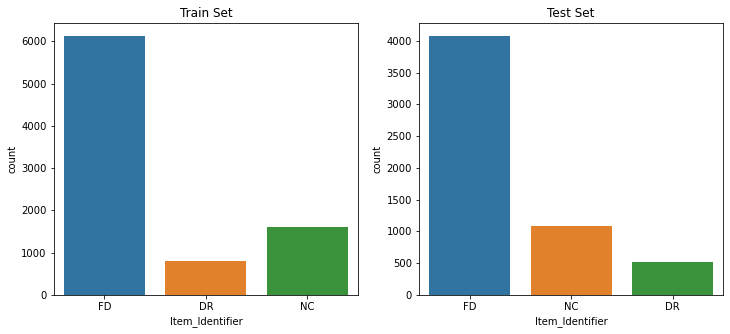

In [64]:
#Plotting the number of items that belong to these three categories

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Identifier'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Identifier'])

plt.show()

#### Item_Fat_Content

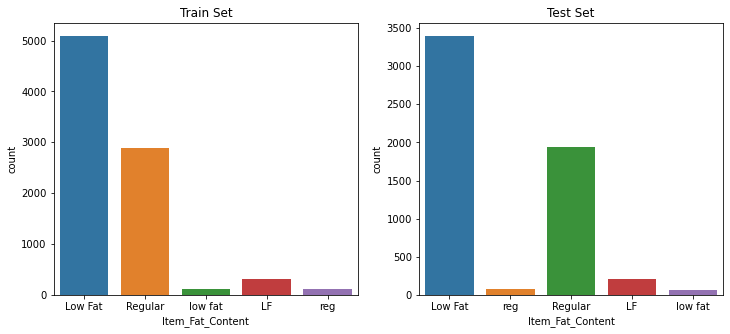

In [65]:
#Plotting the number of items in the Item_Fat_Content column

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Fat_Content'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Fat_Content'])

plt.show()

It looks like 'LF' and 'low fat' are the same as the category 'Low Fat'. The same applies to 'reg' and 'Regular'.

In [66]:
#Substituting 'Low Fat' inplace of 'low fat' and 'LF'

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('low fat', 'Low Fat', x))
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('LF', 'Low Fat', x))

test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('low fat', 'Low Fat', x))
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('LF', 'Low Fat', x))


#Substituting 'Regular' inplace of 'reg'

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('reg', 'Regular', x))
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('reg', 'Regular', x))

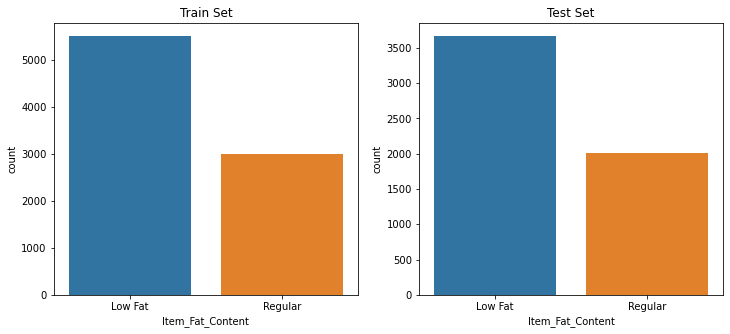

In [67]:
#Checking the Item_Fat_Content column again

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Fat_Content'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Fat_Content'])

plt.show()

#### Item_Type

In [68]:
print(train_df['Item_Type'].unique(), "\n")
print("Number of item types: ", len(train_df['Item_Type'].unique()))

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood'] 

Number of item types:  16


In [91]:
train_df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

#### Outlet_Identifier

In [69]:
print(train_df['Outlet_Identifier'].unique(), "\n")
print("Number of outlets: ", len(train_df['Outlet_Identifier'].unique()))

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019'] 

Number of outlets:  10


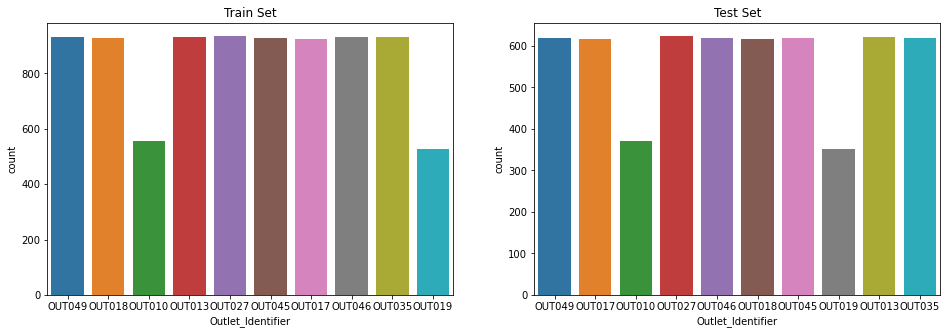

In [70]:
#Checking the Outlet_Identifier column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Identifier'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Identifier'])

plt.show()

#### Outlet_Establishment_Year

In [71]:
print(train_df['Outlet_Establishment_Year'].unique(), "\n")
print("Number of outlets: ", len(train_df['Outlet_Establishment_Year'].unique()))

[1999 2009 1998 1987 1985 2002 2007 1997 2004] 

Number of outlets:  9


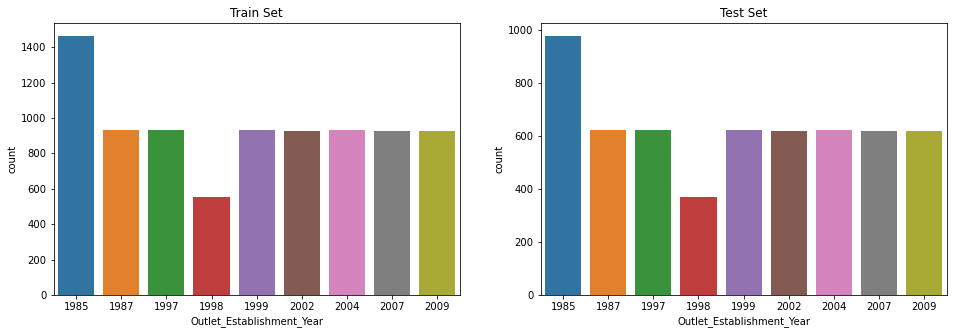

In [72]:
#Checking the Outlet_Establishment_Year column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Establishment_Year'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Establishment_Year'])

plt.show()

Since the year of establishing an outlet cannot be used directly in a model, I'll convert these years into age of the outlet.

In [73]:
#I'll consider the age of the outlet in the year 2010
train_df['Outlet_Establishment_Year'] = 2010 - train_df['Outlet_Establishment_Year']
test_df['Outlet_Establishment_Year'] = 2010 - test_df['Outlet_Establishment_Year']

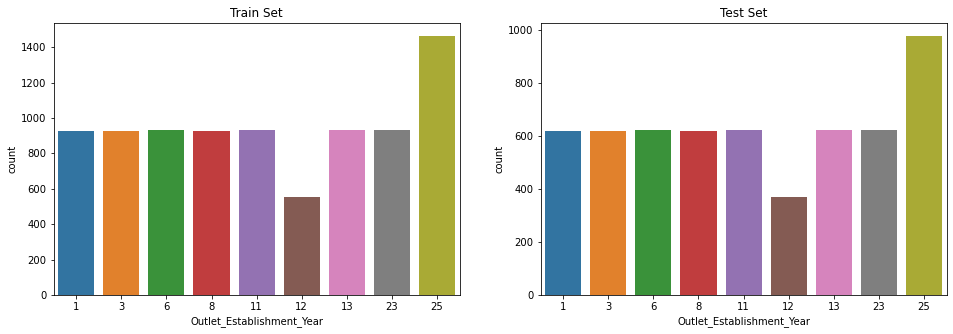

In [74]:
#Checking the Outlet_Establishment_Year column again

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Establishment_Year'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Establishment_Year'])

plt.show()

As we can see from these graphs, most outlets were established in 1985 and are 25 years old in the year 2010.

#### Outlet_Size

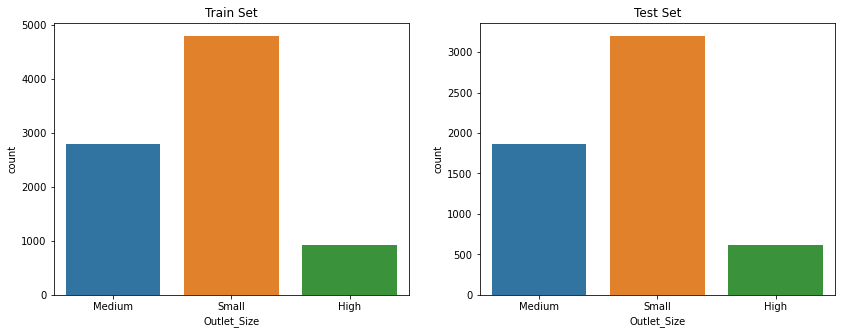

In [75]:
#Checking the Outlet_Size column

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Size'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Size'])

plt.show()

#### Outlet_Location_Type

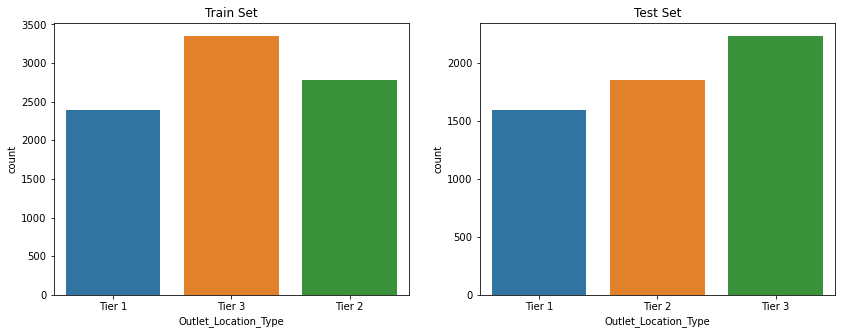

In [76]:
#Checking the Outlet_Location_Type column

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Location_Type'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Location_Type'])

plt.show()

#### Outlet_Type

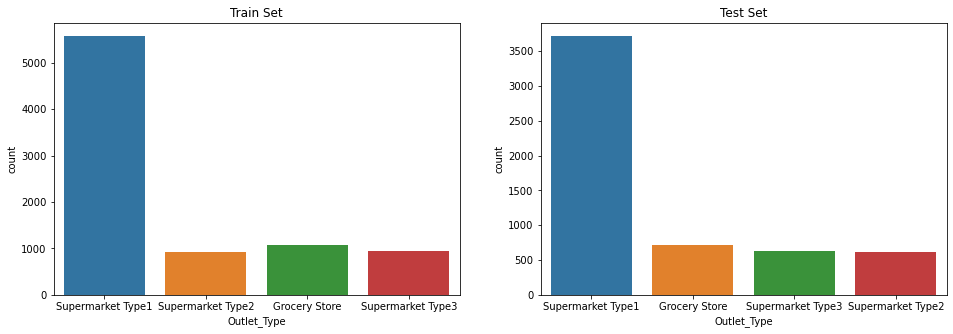

In [77]:
#Checking the Outlet_Type column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Type'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Type'])

plt.show()

#### Continous Variables

In [78]:
#Checking the spread of continous variables
train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.066132,140.992782,12.168133
std,4.645893,0.051598,62.275067,8.371760
min,4.555000,0.000000,31.290000,1.000000
25%,8.785000,0.026989,93.826500,6.000000
50%,12.600000,0.053931,143.012800,11.000000
75%,16.850000,0.094585,185.643700,23.000000
max,21.350000,0.328391,266.888400,25.000000


There don't appear to be any outliers. The minimum value in the Item_Visibility column is zero. If the item is on display in the outlet, the visibility percentage should not be zero. I'll check if Item_Outlet_Sales = 0 when Item_Visibility = 0, as this would indicate that the item is not on the shelves of the outlet.

In [79]:
#Checking if an item is not on the shelves of an outlet when the visibility is zero
train_df[(train_df['Item_Visibility']==0) & (train_df['Item_Outlet_Sales']==0)]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


It looks like the item is present on the shelf, as it has a corresponding sales figure.

In [80]:
#Checking if the item visibility is zero only in a particular outlet

print("Number of outlets: ", len(train_df['Outlet_Identifier'].unique()))
print("Number of outlets with item visibility zero for an item: ", 
      len(train_df['Outlet_Identifier'][train_df['Item_Visibility']==0].unique()))

Number of outlets:  10
Number of outlets with item visibility zero for an item:  10


In [81]:
#Checking if the item visibility is zero only for a particular item

print("Number of items: ", len(train_df['Item_Type'].unique()))
print("Number of items with item visibility zero: ", 
      len(train_df['Item_Type'][train_df['Item_Visibility']==0].unique()))

Number of items:  16
Number of items with item visibility zero:  16


It looks like all items have zero visibility in one outlet or another. Similarly, all outlets have at least one item with zero visibility. This is unlikely to be a data entry error and more likely to be a result of rounding values lower than a threshold value to zero.

In [82]:
#Checking for the lowest non-zero values in the Item_Visibility column
print("Number of rows where 0 < Item_Visibility < 0.01: ", train_df[(train_df['Item_Visibility'] < 0.01) & (train_df['Item_Visibility'] > 0)].shape[0])
print("Number of rows where 0 < Item_Visibility < 0.001: ", train_df[(train_df['Item_Visibility'] < 0.001) & (train_df['Item_Visibility'] > 0)].shape[0])

Number of rows where 0 < Item_Visibility < 0.01:  206
Number of rows where 0 < Item_Visibility < 0.001:  0


It looks like values lower than 0.001 have been rounded to zero in this column. I'll add 0.001 to all values of this column, as Item_Visibility is a percentage and 0.001 = 0.1%

In [83]:
#Checking if the test set also has zero values in the Item_Visibility column
test_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,5681.000000,5681.000000,5681.000000,5681.000000
mean,12.672996,0.065684,141.023273,12.171097
std,4.658256,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1.000000
25%,8.615000,0.027047,94.412000,6.000000
50%,12.350000,0.054154,141.415400,11.000000
75%,16.700000,0.093463,186.026600,23.000000
max,21.350000,0.323637,266.588400,25.000000


Adding 0.001 to all Item_Visibility values.

In [84]:
train_df['Item_Visibility'] = train_df['Item_Visibility'] + 0.001
test_df['Item_Visibility'] = test_df['Item_Visibility'] + 0.001

In [85]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FD,20.750,Low Fat,0.008565,Snack Foods,107.8622,OUT049,11,Medium,Tier 1,Supermarket Type1
1,FD,8.300,Regular,0.039428,Dairy,87.3198,OUT017,3,Small,Tier 2,Supermarket Type1
2,NC,14.600,Low Fat,0.100575,Others,241.7538,OUT010,12,Small,Tier 3,Grocery Store
3,FD,7.315,Low Fat,0.016388,Snack Foods,155.0340,OUT017,3,Small,Tier 2,Supermarket Type1
4,FD,13.600,Regular,0.119599,Dairy,234.2300,OUT027,25,Medium,Tier 3,Supermarket Type3


## Data Preparation

In [86]:
train_df.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.300,Low Fat,0.017047,Dairy,249.8092,OUT049,11,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,5.920,Regular,0.020278,Soft Drinks,48.2692,OUT018,1,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,17.500,Low Fat,0.017760,Meat,141.6180,OUT049,11,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,19.200,Regular,0.001000,Fruits and Vegetables,182.0950,OUT010,12,Small,Tier 3,Grocery Store,732.3800
4,NC,8.930,Low Fat,0.001000,Household,53.8614,OUT013,23,High,Tier 3,Supermarket Type1,994.7052
5,FD,10.395,Regular,0.001000,Baking Goods,51.4008,OUT018,1,Medium,Tier 3,Supermarket Type2,556.6088
6,FD,13.650,Regular,0.013741,Snack Foods,57.6588,OUT013,23,High,Tier 3,Supermarket Type1,343.5528
7,FD,19.000,Low Fat,0.128470,Snack Foods,107.7622,OUT027,25,Medium,Tier 3,Supermarket Type3,4022.7636
8,FD,16.200,Regular,0.017687,Frozen Foods,96.9726,OUT045,8,Small,Tier 2,Supermarket Type1,1076.5986
9,FD,19.200,Regular,0.095450,Frozen Foods,187.8214,OUT017,3,Small,Tier 2,Supermarket Type1,4710.5350


### Encoding Categorical Data

In [87]:
#Creating an object of the OneHotEncoder class
enc = OneHotEncoder()

In [89]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels = enc.fit_transform(train_df[['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                           'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Identifier', 'Item_Type']])


#Using the original column names to make the encoded columns easier to read

col_names = enc.get_feature_names(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                   'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Identifier', 'Item_Type'])

In [90]:
#Converting the encoded columns into a dataframe

encoded_columns = pd.DataFrame(onehotlabels.toarray().astype(int), columns = col_names)
encoded_columns.columns

Index(['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Identifier_NC',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Ty

In [92]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns = encoded_columns.drop(['Item_Identifier_NC', 'Item_Fat_Content_Low Fat', 'Outlet_Size_High', 
                                       'Outlet_Location_Type_Tier 1', 'Outlet_Type_Supermarket Type2', 
                                        'Outlet_Identifier_OUT019', 'Item_Type_Seafood'], axis =1)

In [93]:
print("Shape of encoded columns:\n", encoded_columns.shape)
print("\n")
print("Shape of original train set: \n", train_df.shape)

Shape of encoded columns:
 (8523, 34)


Shape of original train set: 
 (8523, 12)


Merging these encoded columns with the original dataframe

In [94]:
train_df = pd.concat([train_df, encoded_columns], axis = 1)

In [95]:
#Dropping the columns that have been encoded
train_df = train_df.drop(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 
                          'Outlet_Type', 'Outlet_Identifier', 'Item_Type'], axis = 1)

In [96]:
train_df.shape

(8523, 39)

In [97]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,...,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,9.30,0.017047,249.8092,11,3735.1380,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5.92,0.020278,48.2692,1,443.4228,1,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,17.50,0.017760,141.6180,11,2097.2700,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,19.20,0.001000,182.0950,12,732.3800,0,1,1,0,1,...,0,1,0,0,0,0,0,0,0,0
4,8.93,0.001000,53.8614,23,994.7052,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Moving the target variable column to the end

In [98]:
#Getting a list of column names to rearrange them
cols = train_df.columns.tolist()
cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'Item_Identifier_DR',
 'Item_Identifier_FD',
 'Item_Fat_Content_Regular',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type3',
 'Outlet_Identifier_OUT010',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Ite

In [99]:
#Putting target variable at the end
cols = cols[:4] + cols[5:] + [cols[4]]
train_df = train_df[cols]
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Item_Outlet_Sales
0,9.30,0.017047,249.8092,11,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3735.1380
1,5.92,0.020278,48.2692,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,443.4228
2,17.50,0.017760,141.6180,11,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,2097.2700
3,19.20,0.001000,182.0950,12,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,732.3800
4,8.93,0.001000,53.8614,23,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,994.7052


### Encoding the test data

In [100]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels_test = enc.transform(test_df[['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                           'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Identifier', 'Item_Type']])

In [101]:
#Converting the encoded columns into a dataframe and using the same col_names variable that was created for the train set

encoded_columns_test = pd.DataFrame(onehotlabels_test.toarray().astype(int), columns = col_names)
encoded_columns_test.columns

Index(['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Identifier_NC',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Ty

In [102]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns_test = encoded_columns_test.drop(['Item_Identifier_NC', 'Item_Fat_Content_Low Fat', 'Outlet_Size_High', 
                                       'Outlet_Location_Type_Tier 1', 'Outlet_Type_Supermarket Type2', 
                                                 'Outlet_Identifier_OUT019', 'Item_Type_Seafood'], axis =1)

In [103]:
#Merging the encoded columns with the original dataframe

test_df = pd.concat([test_df, encoded_columns_test], axis = 1)

In [104]:
#Dropping the columns that have been encoded
test_df = test_df.drop(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 
                          'Outlet_Type', 'Outlet_Identifier', 'Item_Type'], axis = 1)

### Scaling the continuous variables

In [105]:
train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.067132,140.992782,12.168133
std,4.645893,0.051598,62.275067,8.371760
min,4.555000,0.001000,31.290000,1.000000
25%,8.785000,0.027989,93.826500,6.000000
50%,12.600000,0.054931,143.012800,11.000000
75%,16.850000,0.095585,185.643700,23.000000
max,21.350000,0.329391,266.888400,25.000000


In [106]:
#Creating a standard scaler object
scaler = StandardScaler()

In [107]:
#Making a list of columns that are to be scaled
var_for_scaling = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [108]:
#Scaling the columns
train_df[var_for_scaling] = scaler.fit_transform(train_df[var_for_scaling])

In [109]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Item_Outlet_Sales
0,-0.769246,-0.970732,1.747454,-0.139541,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3735.1380
1,-1.496813,-0.908111,-1.489023,-1.334103,1,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,443.4228
2,0.995858,-0.956917,0.010040,-0.139541,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,2097.2700
3,1.361794,-1.281758,0.660050,-0.020085,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,732.3800
4,-0.848890,-1.281758,-1.399220,1.293934,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,994.7052


In [110]:
#Scaling the columns in the test set
test_df[var_for_scaling] = scaler.transform(test_df[var_for_scaling])

In [111]:
test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,1.695442,-1.135138,-0.532035,-0.139541,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-0.984502,-0.536960,-0.861920,-1.095190,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0.371614,0.648183,1.618094,-0.020085,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,-1.196530,-0.983503,0.225484,-1.095190,0,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
4,0.156357,1.016910,1.497272,1.532846,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting the data set

In [112]:
#Splitting the data 70-30

train_df, val_df = train_test_split(train_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [113]:
#Splitting into X_train and y_train (and X_val and y_val)

y_train = train_df.pop('Item_Outlet_Sales')
X_train = train_df

y_val = val_df.pop('Item_Outlet_Sales')
X_val = val_df

In [114]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5966, 38)
(5966,)
(2557, 38)
(2557,)


## Model Building

### 1. Linear Regression Model

In [115]:
#Creating a linear regression object with an intercept
lm = LinearRegression(fit_intercept=True)

#Fitting the model on the train set
lm.fit(X_train, y_train)

LinearRegression()

In [116]:
#Making predictions on the train and validation set
y_train_predictions_lr = lm.predict(X_train)
y_val_predictions_lr = lm.predict(X_val)

#Calculating the RMSE for the train and val sets
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predictions_lr))
lr_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions_lr))

print('Train dataset RMSE: ', round(lr_train_rmse, 4))
print('Validation dataset RMSE: ', round(lr_val_rmse, 4))

Train dataset RMSE:  1134.9717
Validation dataset RMSE:  1132.3674


In [117]:
#Calculating the R-squared value for the train and val sets
lr_train_score = r2_score(y_train, y_train_predictions_lr)
lr_val_score = r2_score(y_val, y_val_predictions_lr)

print("Train set R-squared value: {:.4f}" .format(lr_train_score))
print("Validation set R-squared value: {:.4f}" .format(lr_val_score))

Train set R-squared value: 0.5625
Validation set R-squared value: 0.5479


### 2. Decision Tree Model

In [118]:
#Creating the parameter grid
param_grid = {
    'max_depth': [4, 8, 12, 16],
    'min_samples_leaf': [10, 25, 50, 75, 100, 125],
    'max_leaf_nodes': [10, 25, 50, 75, 100, 125, 150],
    'max_features' : ['auto', 'log2']
}

n_folds = 5

# Instantiate the grid search model
dtree_grid = DecisionTreeRegressor(random_state=100, criterion = 'mse')
grid_search_dtree = GridSearchCV(estimator = dtree_grid, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, n_jobs=-1)

# Fit the grid search to the data
grid_search_dtree.fit(X_train, y_train)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:   12.0s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 12, 16],
                         'max_features': ['auto', 'log2'],
                         'max_leaf_nodes': [10, 25, 50, 75, 100, 125, 150],
                         'min_samples_leaf': [10, 25, 50, 75, 100, 125]},
             verbose=1)

In [119]:
# printing the optimal accuracy score and hyperparameters
print("best score", grid_search_dtree.best_score_)
print(grid_search_dtree.best_estimator_)

best score 0.5876295097686294
DecisionTreeRegressor(max_depth=8, max_features='auto', max_leaf_nodes=50,
                      min_samples_leaf=125, random_state=100)


In [120]:
# model with optimal hyperparameters
dtree = DecisionTreeRegressor(max_depth=8,
                              max_features = 'auto',
                              max_leaf_nodes=50,
                              min_samples_leaf=125,
                              random_state = 100,
                              criterion = 'mse'
                             )

dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, max_features='auto', max_leaf_nodes=50,
                      min_samples_leaf=125, random_state=100)

In [121]:
#Making predictions on the train and validation set
y_train_predictions_dtree = dtree.predict(X_train)
y_val_predictions_dtree = dtree.predict(X_val)

#Calculating the RMSE for the train and val sets
dtree_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predictions_lr))
dtree_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions_lr))

print('Train dataset RMSE: ', round(dtree_train_rmse, 4))
print('Validation dataset RMSE: ', round(dtree_val_rmse, 4))

Train dataset RMSE:  1134.9717
Validation dataset RMSE:  1132.3674


### 3. Random Forest

In [122]:
#Creating the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 175, 200],
    'max_depth': [4, 6, 8, 12, 14],
    'min_samples_leaf': [10, 25, 50, 75, 100],
    'max_leaf_nodes': [10, 25, 50, 75, 100],
    'max_features' : ['auto', 'log2']
}

n_folds = 5

# Instantiate the grid search model
rf_grid = RandomForestRegressor(random_state=100, criterion = 'mse')
grid_search_rf = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1250 candidates, totalling 6250 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 6250 out of 6250 | elapsed: 11.7min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 12, 14],
                         'max_features': ['auto', 'log2'],
                         'max_leaf_nodes': [10, 25, 50, 75, 100],
                         'min_samples_leaf': [10, 25, 50, 75, 100],
                         'n_estimators': [50, 100, 150, 175, 200]},
             verbose=1)

In [123]:
# printing the optimal accuracy score and hyperparameters
print("best score", grid_search_rf.best_score_)
print(grid_search_rf.best_estimator_)

best score 0.5986281965469245
RandomForestRegressor(max_depth=6, max_leaf_nodes=50, min_samples_leaf=25,
                      n_estimators=200, random_state=100)


In [124]:
# model with optimal hyperparameters
rf = RandomForestRegressor(max_depth=6,
                           max_leaf_nodes=50,
                           min_samples_leaf=25,
                           n_estimators=200,
                           random_state=100
                           )

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_leaf_nodes=50, min_samples_leaf=25,
                      n_estimators=200, random_state=100)

In [125]:
#Making predictions on the train and validation set
y_train_predictions_rf = rf.predict(X_train)
y_val_predictions_rf = rf.predict(X_val)

#Calculating the RMSE for the train and val sets
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predictions_rf))
rf_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions_rf))

print('Train dataset RMSE: ', round(rf_train_rmse, 4))
print('Validation dataset RMSE: ', round(rf_val_rmse, 4))

Train dataset RMSE:  1055.2186
Validation dataset RMSE:  1072.9231


### 4. CatBoost

In [126]:
#Defining the parameter grid

param_grid = {'n_estimators': [25, 50, 75, 100],
              'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.25],
              'max_depth': [4, 6, 8, 10],
              'num_leaves': [16, 32, 64, 96, 128],
              'l2_leaf_reg': [0.5, 1, 2, 3, 4, 5]
              }


#Specify the number of folds (note that StratifiedKFold can't be used with a continuous target variable)
n_folds = 5


# Instantiate the LGBM classifier
cb_grid = CatBoostRegressor(random_state = 100,
                              loss_function = 'RMSE'
                            )


grid_search_cb = GridSearchCV(estimator = cb_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_cb.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1614 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 2722 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5777 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7409 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9066 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 11162 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 11977 out of 12000 | elapsed:  3.3min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 12000 out of 12000 | elapsed:  3.4min finished


0:	learn: 1669.3173416	total: 137ms	remaining: 13.6s
1:	learn: 1630.5138409	total: 139ms	remaining: 6.8s
2:	learn: 1593.8345076	total: 141ms	remaining: 4.54s
3:	learn: 1557.7333262	total: 143ms	remaining: 3.42s
4:	learn: 1522.7272600	total: 144ms	remaining: 2.74s
5:	learn: 1493.6880541	total: 145ms	remaining: 2.28s
6:	learn: 1461.9318370	total: 147ms	remaining: 1.95s
7:	learn: 1434.0044219	total: 148ms	remaining: 1.7s
8:	learn: 1406.8213009	total: 150ms	remaining: 1.51s
9:	learn: 1385.3340700	total: 151ms	remaining: 1.36s
10:	learn: 1365.0354782	total: 152ms	remaining: 1.23s
11:	learn: 1343.5160602	total: 165ms	remaining: 1.21s
12:	learn: 1322.9804267	total: 166ms	remaining: 1.11s
13:	learn: 1303.5580981	total: 168ms	remaining: 1.03s
14:	learn: 1286.0762213	total: 169ms	remaining: 958ms
15:	learn: 1269.5054705	total: 180ms	remaining: 947ms
16:	learn: 1255.1504495	total: 182ms	remaining: 887ms
17:	learn: 1241.6706021	total: 183ms	remaining: 834ms
18:	learn: 1228.3914855	total: 185ms	rem

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000025657BF2340>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [0.5, 1, 2, 3, 4, 5],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.25],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [25, 50, 75, 100],
                         'num_leaves': [16, 32, 64, 96, 128]},
             verbose=1)

In [127]:
#Viewing the best parameters from the grid search
print(grid_search_cb.best_params_)
print(grid_search_cb.best_score_)

{'l2_leaf_reg': 4, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 16}
0.602924389501557


In [128]:
#Fitting a CatBoost model
cb_model = CatBoostRegressor(l2_leaf_reg = 5, learning_rate = 0.1, max_depth = 4, n_estimators = 50, 
                             num_leaves = 16)
cb_model.fit(X_train, y_train)

0:	learn: 1627.1344493	total: 1.57ms	remaining: 77.2ms
1:	learn: 1547.0211665	total: 3.23ms	remaining: 77.5ms
2:	learn: 1479.4214387	total: 4.69ms	remaining: 73.5ms
3:	learn: 1420.9791388	total: 6.18ms	remaining: 71.1ms
4:	learn: 1369.9871981	total: 7.53ms	remaining: 67.8ms
5:	learn: 1327.9102030	total: 9.19ms	remaining: 67.4ms
6:	learn: 1296.2277220	total: 10.6ms	remaining: 64.9ms
7:	learn: 1263.9266013	total: 11.9ms	remaining: 62.7ms
8:	learn: 1234.7875826	total: 13.3ms	remaining: 60.6ms
9:	learn: 1214.6217787	total: 14.6ms	remaining: 58.4ms
10:	learn: 1193.5535180	total: 15.9ms	remaining: 56.5ms
11:	learn: 1176.4611003	total: 17.3ms	remaining: 54.8ms
12:	learn: 1162.0411489	total: 18.6ms	remaining: 53.1ms
13:	learn: 1148.8194916	total: 20ms	remaining: 51.3ms
14:	learn: 1137.7548990	total: 21.3ms	remaining: 49.7ms
15:	learn: 1129.7265105	total: 22.7ms	remaining: 48.1ms
16:	learn: 1123.4218504	total: 24ms	remaining: 46.6ms
17:	learn: 1116.5817703	total: 25.4ms	remaining: 45.1ms
18:	le

In [129]:
#Making predictions on the train and validation set
y_train_predictions_cb = cb_model.predict(X_train)
y_val_predictions_cb = cb_model.predict(X_val)

#Calculating the RMSE for the train and val sets
cb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predictions_cb))
cb_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions_cb))

print('Train dataset RMSE: ', round(cb_train_rmse, 4))
print('Validation dataset RMSE: ', round(cb_val_rmse, 4))

Train dataset RMSE:  1067.1881
Validation dataset RMSE:  1071.9376


The CatBoost and Random Forest models have given the lowest validation RMSE of 1069.39 and 1072.12 respectively.

In [130]:
#Making predictions on the test set
y_test_predictions_cb = cb_model.predict(test_df)

In [131]:
y_test_predictions_cb[0:5]

array([1774.00827035, 1375.21890086,  803.87583987, 2446.85159972,
       5861.8568143 ])

In [132]:
test_predictions_df = {'Item_Identifier': test_df_backup['Item_Identifier'], 
                       'Outlet_Identifier': test_df_backup['Outlet_Identifier'], 
                        'Item_Outlet_Sales':y_test_predictions_cb
                      }

In [133]:
test_predictions_df = pd.DataFrame(test_predictions_df)
test_predictions_df.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1774.008270
1,FDW14,OUT017,1375.218901
2,NCN55,OUT010,803.875840
3,FDQ58,OUT017,2446.851600
4,FDY38,OUT027,5861.856814


This gave a score of 1154.17 on the test set. This is marginally lower than the results when hashing was used for encoding categorical columns.

In [134]:
test_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item_Identifier    5681 non-null   object 
 1   Outlet_Identifier  5681 non-null   object 
 2   Item_Outlet_Sales  5681 non-null   float64
dtypes: float64(1), object(2)
memory usage: 133.3+ KB


In [135]:
test_predictions_df.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1774.008270
1,FDW14,OUT017,1375.218901
2,NCN55,OUT010,803.875840
3,FDQ58,OUT017,2446.851600
4,FDY38,OUT027,5861.856814


In [136]:
#Exporting the dataframe to a csv file
test_predictions_df.to_csv('predictions_for_submission.csv', index=False)